<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">GPT-2</h1>
    </div>
</div>

**TL;DR**</br>
This script loads a dataset, preprocesses it for GPT-2 model input, splits it into train, validation, and test sets, trains a GPT-2 model, evaluates it on validation data, and plots its performance metrics such as confusion matrix, ROC, and precision-recall curves.

**Summary**</br>
The code loads a dataset from a SingleStore database. It then preprocesses the data for GPT-2 model input and splits it into train, validation, and test sets. After creating data loaders, it loads a pre-trained GPT-2 model for sequence classification and initialises the optimiser. The script then enters a training loop over several epochs, computing training metrics and validating the model on the validation set. After training, it evaluates the model on the test set and plots its performance metrics using functions to visualise confusion matrix, ROC, and precision-recall curves.

In [11]:
!pip cache purge --quiet

In [12]:
!pip install transformers==4.27.2 --quiet
!pip install scikit-learn --quiet
!pip install torch==1.13.1 --quiet
!pip install matplotlib --quiet

In [13]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import numpy as np

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [14]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [15]:
dataset = pd.read_sql(
    "SELECT Fraud, Filings FROM financial_filings",
    con = db_connection
)

In [16]:
import warnings

warnings.filterwarnings("ignore", category = FutureWarning)

## Preprocessing the data

# Encode Labels
label_encoder = LabelEncoder()
dataset["Fraud"] = label_encoder.fit_transform(dataset["Fraud"])

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# Check if padding token is set, if not, set it
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

text_data = dataset["Filings"].tolist()
encoded_inputs = tokenizer(text_data, padding = "max_length", truncation = True, max_length = 512, return_tensors = "pt")
attention_masks = encoded_inputs["attention_mask"]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


In [17]:
# Split into Training, Validation, and Test Sets
train_inputs, temp_inputs, train_labels, temp_labels, train_masks, temp_masks = train_test_split(
    encoded_inputs["input_ids"], dataset["Fraud"], attention_masks, test_size = 0.4, random_state = 42
)

val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks = train_test_split(
    temp_inputs, temp_labels, temp_masks, test_size = 0.5, random_state = 42
)

In [18]:
# Create DataLoader with attention masks
train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels.values).long())
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels.values).long())
val_dataloader = DataLoader(val_dataset, batch_size = 4)

test_dataset = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels.values).long())
test_dataloader = DataLoader(test_dataset, batch_size = 4)

# Load GPT-2 Model for Sequence Classification
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels = 2)
model.resize_token_embeddings(len(tokenizer) + 1)
model.config.pad_token_id = tokenizer.pad_token_id
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Training Loop with attention masks
num_epochs = 4
total_start_time = time.time()
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    train_predictions = []
    train_true_labels = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask = masks, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(F.softmax(logits, dim = 1), dim = 1)
        train_predictions.extend(predictions.tolist())
        train_true_labels.extend(labels.tolist())
    
    # Training Metrics
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_precision = precision_score(train_true_labels, train_predictions)
    train_recall = recall_score(train_true_labels, train_predictions)
    train_f1 = f1_score(train_true_labels, train_predictions)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss/len(train_dataloader)}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Training F1-score: {train_f1}")

    # Validation Loop
    model.eval()
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask = masks)
            logits = outputs.logits
            predictions = torch.argmax(F.softmax(logits, dim = 1), dim = 1)
            val_predictions.extend(predictions.tolist())
            val_true_labels.extend(labels.tolist())
    
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")

total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/4
Training Loss: 1.0708862050221517
Training Accuracy: 0.45098039215686275
Training Precision: 0.4074074074074074
Training Recall: 0.4782608695652174
Training F1-score: 0.44
Time taken for epoch 1: 247.50 seconds
Epoch 2/4
Training Loss: 0.6488392668274733
Training Accuracy: 0.6568627450980392
Training Precision: 0.627906976744186
Training Recall: 0.5869565217391305
Training F1-score: 0.6067415730337079
Time taken for epoch 2: 245.47 seconds
Epoch 3/4
Training Loss: 0.545891672372818
Training Accuracy: 0.6666666666666666
Training Precision: 0.6764705882352942
Training Recall: 0.5
Training F1-score: 0.575
Time taken for epoch 3: 279.24 seconds
Epoch 4/4
Training Loss: 0.44019178129159486
Training Accuracy: 0.8431372549019608
Training Precision: 0.8571428571428571
Training Recall: 0.782608695652174
Training F1-score: 0.8181818181818182
Time taken for epoch 4: 246.85 seconds
Total training time: 1019.06 seconds


In [20]:
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask = masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average = "weighted")
    recall = recall_score(true_labels, predictions, average = "weighted")
    f1 = f1_score(true_labels, predictions, average = "weighted")

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    return accuracy, precision, recall, f1

evaluate(model, val_dataloader)

Accuracy: 0.7352941176470589
Precision: 0.7616892911010558
Recall: 0.7352941176470589
F1 Score: 0.7318324016616238


(0.7352941176470589,
 0.7616892911010558,
 0.7352941176470589,
 0.7318324016616238)

In [21]:
def plot_graphs(true_labels, predictions, probas = None):
    # 1. Plot the Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Non-Fraudulent", "Fraudulent"])
    disp.plot(cmap = plt.cm.Reds)
    plt.title("Confusion Matrix for Test Data")
    plt.show()

    if probas is not None:
        # 2. Plot the ROC Curve
        fpr, tpr, _ = roc_curve(true_labels, probas[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = "GPT-2 Model")
        roc_display.plot()
        plt.title("ROC Curve for Test Data")
        plt.show()

        # 3. Plot the Precision-Recall Curve
        precision_curve, recall_curve, _ = precision_recall_curve(true_labels, probas[:, 1])
        pr_display = PrecisionRecallDisplay(precision = precision_curve, recall = recall_curve)
        pr_display.plot()
        plt.title("Precision-Recall Curve for Test Data")
        plt.show()

Accuracy: 0.6764705882352942
Precision: 0.6954656862745098
Recall: 0.6764705882352942
F1 Score: 0.6807614292401309


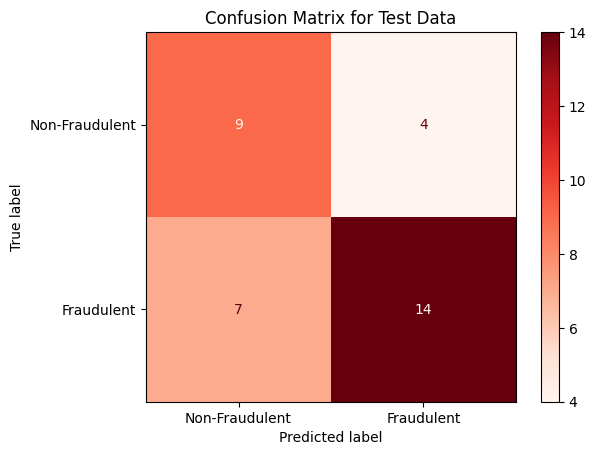

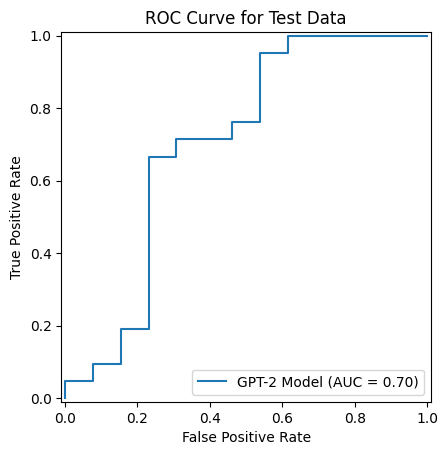

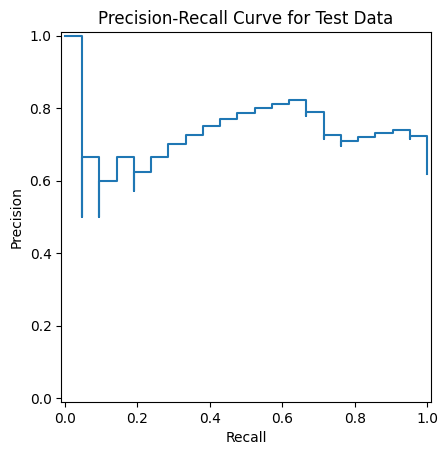

(0.6764705882352942,
 0.6954656862745098,
 0.6764705882352942,
 0.6807614292401309)

In [22]:
def evaluate_and_plot(model, dataloader):
    model.eval()
    predictions, true_labels, probabilities = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask = masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            probabilities.extend(F.softmax(logits, dim = 1).tolist())
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average = "weighted")
    recall = recall_score(true_labels, predictions, average = "weighted")
    f1 = f1_score(true_labels, predictions, average = "weighted")

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    
    plot_graphs(true_labels, predictions, np.array(probabilities))

    return accuracy, precision, recall, f1

evaluate_and_plot(model, test_dataloader)

[Financial-Fraud-Detection-Using-LLMs](https://github.com/amitkedia007/Financial-Fraud-Detection-Using-LLMs)

## MIT License

Copyright (c) 2023 Amit Kedia

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.